In [1]:
import pandas as pd
import numpy as np
from src.scripts import timeseries_anim
import json
from src.scripts.clinical_trials import (
    combine_trials_json,
    plot_clinical_counts,
    classify_disease,
    load_clinical_trials_data,
)

In [2]:
df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "DrugBank ID of Ligand",
        "IC50 (nM)",
        "Article DOI",
        "Institution",
        "Patent Number",
        "ZINC ID of Ligand",
    ],
)

C:\Users\grede\AppData\Local\Temp\ipykernel_6856\2446788585.py:1: DtypeWarning: Columns (9,17,21,23,33,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [3]:
# load initial data
uniprot_ids = [
    "P07949",
    "P14416",
]  # ["P03367", "P37238"]  # TODO: find RET and other interestig ones
targets = timeseries_anim.filter_RET(df, uniprot_ids=uniprot_ids)

In [4]:
uniprot_ids_names_mapping = {"P07949": "RET", "P14416": "D(2) dopamine receptor"}

In [5]:
targets = targets.drop_duplicates(subset=["Ligand SMILES"])

In [6]:
# citations
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations = pd.DataFrame(citations)

# merge
targets = (
    pd.merge(
        left=targets,
        right=citations,
        left_on="Article DOI",
        right_on="doi",
        how="outer",
    )
    .dropna(subset="Ligand SMILES")
    .drop(columns="Article DOI")
)

In [7]:
# patents
with open("../src/data/patents.json", "r") as f:
    patents = json.load(f)
patents_df = pd.DataFrame(
    [
        {
            "patent": patent["patent"],
            "patent_status": patent["info"].get("status", np.nan),
            "families citing": int(patent["info"].get("families citing", 0) or 0),
            "cited by": int(patent["info"].get("cited by", 0) or 0),
        }
        for patent in patents
        if isinstance(patent, dict) and isinstance(patent.get("info"), dict)
    ]
)
patents_df["patent_citations"] = patents_df["families citing"] + patents_df["cited by"]
patents_df.drop(columns=["families citing", "cited by"], inplace=True)

# merge
targets = (
    pd.merge(
        left=targets,
        right=patents_df,
        left_on="Patent Number",
        right_on="patent",
        how="outer",
    )
    .dropna(subset="Ligand SMILES")
    .drop(columns="Patent Number")
)

In [8]:
# TODO: clinical trials: check clinical_trials.ipynb and understand how to get the graphs
# count data into the current df (by merging on ZINC IDs, which are already in 'targets')
paths = [
    "../src/data/ZINC_references_trials_amel.json",
    "../src/data/ZINC_references_trials_daphne.json",
    "../src/data/ZINC_references_trials_wes.json",
    "../src/data/ZINC_references_trials_greg.json",
    "../src/data/ZINC_references_trials_guillaume.json",
]
df_all = combine_trials_json(paths)

In [9]:
phase_4_count_df = (
    df_all.query("status_name == 'Completed'")
    .value_counts(["ZINC ID of Ligand", "phase_name"])
    .reset_index()
    .query("phase_name == 'Phase 4'")
    .rename(columns={"count": "phase_4_count"})
    .drop(columns="phase_name")
)

In [10]:
# merge
targets = pd.merge(
    left=targets,
    right=phase_4_count_df,
    left_on="ZINC ID of Ligand",
    right_on="ZINC ID of Ligand",
    how="outer",
).dropna(subset="Ligand SMILES")

In [11]:
# clean IC50
targets.replace(" NV,", np.nan, inplace=True)
targets["IC50 (nM)"] = targets["IC50 (nM)"].astype(str).str.replace(" C", "")
targets["IC50 (nM)"] = (
    targets["IC50 (nM)"]
    .astype(str)
    .str.replace(">", "")
    .str.replace("<", "")
    .astype(float)
)
targets["log(IC50+1) (nM)"] = (targets["IC50 (nM)"] + 1).apply(np.log10)
# targets.drop(columns="IC50 (nM)", inplace=True)

In [12]:
# fingerprints
targets = timeseries_anim.get_ligands_fingerprint(targets)

[18:28:19] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:28:20] Explicit valence for atom # 35 N, 4, is greater than permitted
[18:28:21] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:28:21] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:28:22] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:28:22] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[18:28:22] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[18:28:22] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[18:28:22] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[18:28:22] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[18:28:22] Explicit valence for atom # 32 O, 3, is greater than permitted
[18:28:22] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[18:28:22] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:28:23] Can't 

In [13]:
# pca applied to each target seperately
store = []
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    temp = targets[
        targets["UniProt (SwissProt) Primary ID of Target Chain"] == target
    ].copy()
    temp, _, _ = timeseries_anim.PCA_fingerprints(temp)
    store.append(temp)
result = pd.concat(store, ignore_index=True)

## final data has info for pca overlayed with:
# - ic50
# - citations (article)
# - patent citations

In [14]:
result = result.drop_duplicates(subset=["Ligand SMILES"])

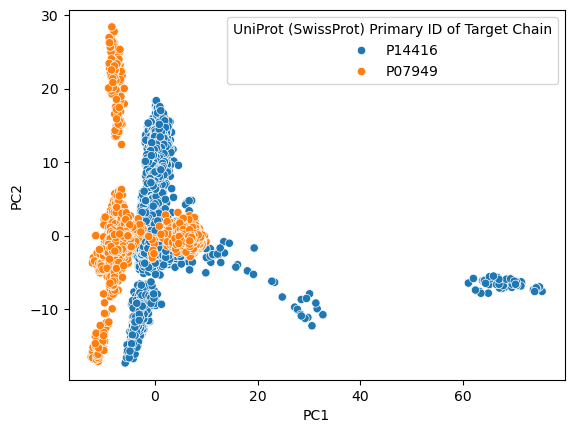

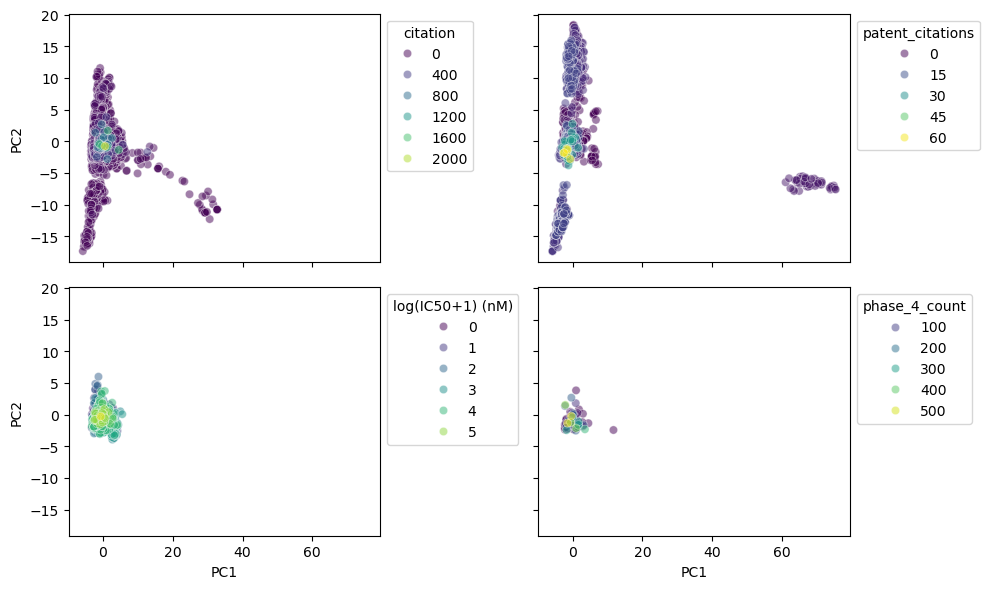

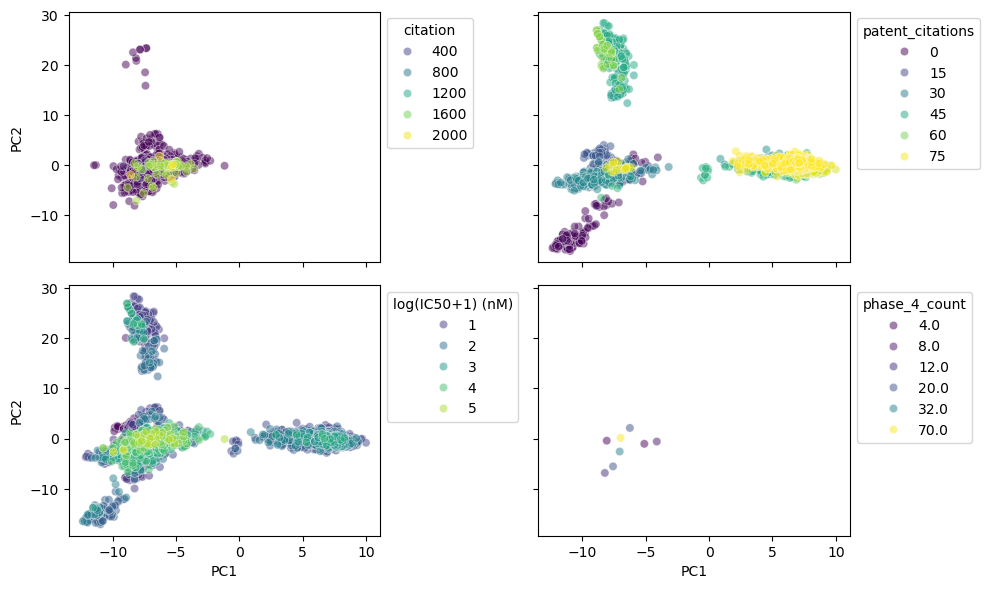

In [15]:
# examples:
import seaborn as sns
from matplotlib import pyplot as plt

# pcas of each target
sns.scatterplot(
    result, x="PC1", y="PC2", hue="UniProt (SwissProt) Primary ID of Target Chain"
)
plt.show()

# seperating each pca and overlaying stuff
# TODO: plotly
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 6))
    for ax, hue in zip(
        axs.flatten(),
        ["citation", "patent_citations", "log(IC50+1) (nM)", "phase_4_count"],
    ):
        sns.scatterplot(
            result[
                result["UniProt (SwissProt) Primary ID of Target Chain"] == target
            ].sort_values(hue),
            x="PC1",
            y="PC2",
            hue=hue,
            ax=ax,
            palette="viridis",
            alpha=0.5,
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [16]:
uniprot_ids_names_mapping

{'P07949': 'RET', 'P14416': 'D(2) dopamine receptor'}

In [17]:
import plotly.graph_objects as go
from src.scripts.save_plotly import save_plotly

for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    result_ = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == target]

    # Compute the global x and y ranges based on the full dataset
    x_range = [1.1 * result_["PC1"].min(), 1.1 * result_["PC1"].max()]
    y_range = [1.1 * result_["PC2"].min(), 1.1 * result_["PC2"].max()]

    # Create a base figure
    fig = go.Figure()

    # List of hue variables
    hue_variables = [
        "citation",
        "patent_citations",
        "log(IC50+1) (nM)",
        "phase_4_count",
    ]
    title = f"{uniprot_ids_names_mapping[target]} Ligand Fingerprint PC1 vs PC2"

    # Loop through each hue variable, filter out NaN values, and add as a separate trace
    for hue in hue_variables:
        filtered_data = result_.dropna(subset=[hue]).sort_values(
            hue
        )  # Drop rows where hue has NaN
        fig.add_trace(
            go.Scatter(
                x=filtered_data["PC1"],
                y=filtered_data["PC2"],
                mode="markers",
                marker=dict(
                    size=8,
                    color=filtered_data[hue],
                    colorscale="Viridis",
                    showscale=True,
                    # opacity=0.5,
                    colorbar=dict(
                        title=hue.capitalize().replace("_", " ")
                    ),  # Custom colorbar title
                ),
                name=hue,  # Name will be used in the dropdown menu
                visible=False,  # Initially hidden; we will toggle visibility
                # hoverinfo=hue,
            )
        )

    # Set the first trace to be visible initially
    fig.data[0].visible = True

    # Create dropdown menu
    dropdown_buttons = [
        dict(
            label=hue.capitalize().replace("_", " "),
            method="update",
            args=[
                {
                    "visible": [i == idx for i in range(len(hue_variables))]
                },  # Toggle visibility
                {
                    "title": f"{title} with {hue.capitalize().replace('_', ' ')} overlayed"
                },  # Update title dynamically
            ],
        )
        for idx, hue in enumerate(hue_variables)
    ]

    # Add dropdown menu and set consistent x and y ranges in layout
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction="down",
                showactive=True,
                # x=0.1,  # Position of the dropdown menu
                # y=1.15,
            )
        ],
        title={
            "text": title,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        xaxis=dict(title="PC1", range=x_range),  # Fixed x-axis range
        yaxis=dict(title="PC2", range=y_range),  # Fixed y-axis range
        template="plotly_dark",
    )

    # save_plotly(
    #     fig,
    #     f"../frontend/figures/{uniprot_ids_names_mapping[target].replace(' ', '_')}_2D_PCA_overlays",
    # )

    # # Show the figure
    # fig.show()

In [18]:
result_ = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == "P14416"]

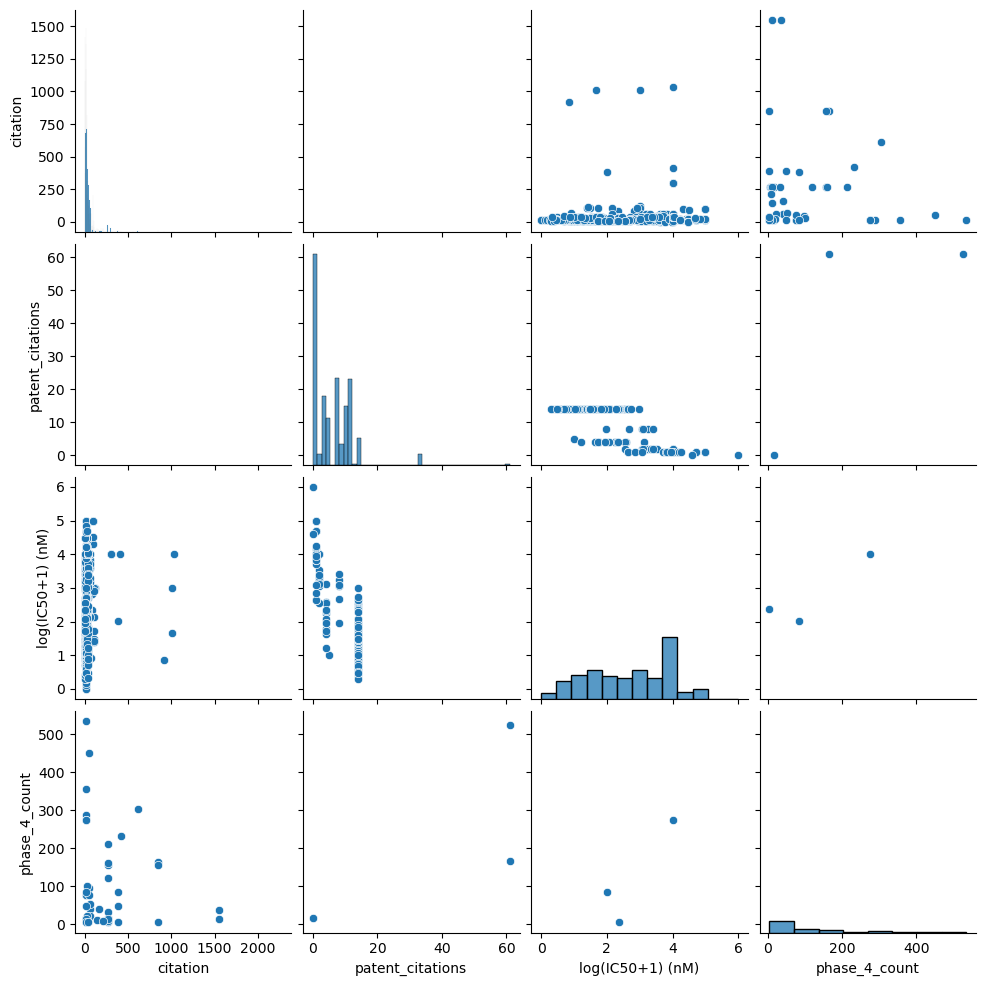

In [19]:
sns.pairplot(
    result_[["citation", "patent_citations", "log(IC50+1) (nM)", "phase_4_count"]]
)

# Clustering

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [21]:
def kmeans_selection(data, range):
    scores = []
    for k in range:
        kmeans = KMeans(n_clusters=k, random_state=10).fit(data[["PC1", "PC2", "PC3"]])
        labels = kmeans.predict(data[["PC1", "PC2", "PC3"]])
        score = silhouette_score(data[["PC1", "PC2", "PC3"]], labels)
        scores.append({"k": k, "silhouette_score": score, "sse": kmeans.inertia_})
    return scores


result = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"]
kmeans_selection_df = pd.DataFrame(
    kmeans_selection(result[["PC1", "PC2", "PC3"]], range(2, 10))
)
kmeans_selection_df

,k,silhouette_score,sse
0,2,0.616023,265517.580958
1,3,0.688872,151845.450433
2,4,0.729252,72021.933666
3,5,0.715673,35040.286528
4,6,0.683126,26745.988391
5,7,0.470954,24344.673663
6,8,0.460332,19631.336342
7,9,0.454069,17241.659820


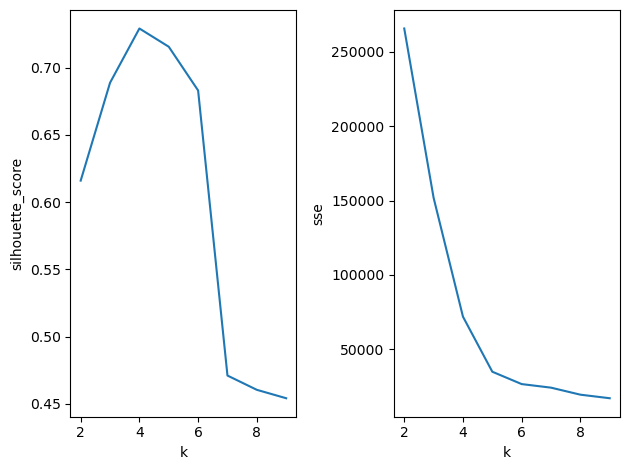

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.lineplot(kmeans_selection_df, x="k", y="silhouette_score", ax=ax1)
sns.lineplot(kmeans_selection_df, x="k", y="sse", ax=ax2)
plt.tight_layout()
plt.show()

In [23]:
kmeans = KMeans(n_clusters=5, random_state=10).fit(result[["PC1", "PC2", "PC3"]])
result["cluster"] = kmeans.predict(result[["PC1", "PC2", "PC3"]]).astype(str)

In [24]:
import plotly.express as px
import plotly.graph_objects as go

# Scatter plot for the points
fig = px.scatter_3d(
    result.sort_values("cluster"),
    x="PC1",
    y="PC2",
    z="PC3",
    color="cluster",
    template="plotly_dark",
    opacity=0.5,
)

# Update marker size for the main plot
fig.update_traces(marker=dict(size=2))

# Add centroids to the figure
centroids = kmeans.cluster_centers_
fig.add_trace(
    go.Scatter3d(
        x=centroids[:, 0],  # Assuming PC1, PC2, and PC3 are the first 3 components
        y=centroids[:, 1],
        z=centroids[:, 2],
        mode="markers",
        marker=dict(
            size=3,
            color="white",  # Change this to your desired color
            symbol="x",  # Change this to your desired symbol (e.g., 'diamond', 'cross', etc.)
        ),
        name="Centroids",
        opacity=0.5,
    )
)

# Update layout
fig.update_layout(
    title={
        "text": "PCA K-Means Clustering on RET Ligands",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    scene=dict(
        aspectmode="cube",  # Ensures fixed proportions for the axes
    ),
)

# # Show the plot
# save_plotly(fig, "../frontend/figures/data_story/kmeans_RET")

# # Show the plot
# fig.show()

In [25]:
result.groupby("cluster").aggregate(
    {"log(IC50+1) (nM)": "mean", "IC50 (nM)": "mean"}
).sort_values("log(IC50+1) (nM)")

,log(IC50+1) (nM),IC50 (nM)
cluster,,
4,1.095719,452.488581
0,1.509901,89.657547
2,1.556228,350.161435
3,1.856558,120.605263
1,2.523534,8146.974066


<Axes: ylabel='log(IC50+1) (nM)'>

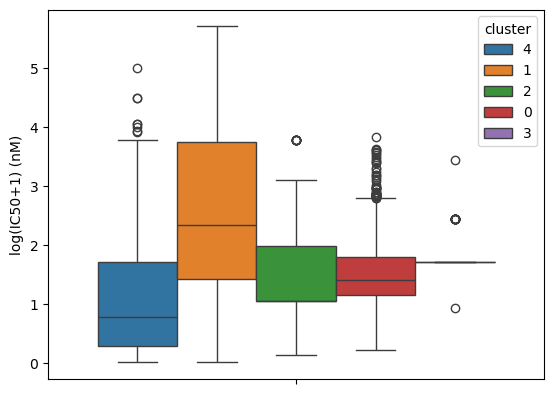

In [26]:
sns.boxplot(result.sort_values("log(IC50+1) (nM)"), hue="cluster", y="log(IC50+1) (nM)")

In [27]:
import plotly.express as px
from src.scripts.save_plotly import save_plotly

# Create the boxplot with Plotly Express
fig = px.box(
    result.sort_values("log(IC50+1) (nM)"),
    y="log(IC50+1) (nM)",
    color="cluster",
    template="plotly_dark",
    category_orders={"cluster": sorted(result["cluster"].unique())},
)

# Update layout
fig.update_layout(
    title={
        "text": "Distribution of log(IC50+1) for each RET ligand cluster",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
)

# # Show the plot
# save_plotly(fig, "../frontend/figures/data_story/boxplot_RET_ligand_cluster")
# fig.show()

In [28]:
from src.scripts import smiles
from tqdm.notebook import tqdm


def cluster_representatives(result_with_kmeans: pd.DataFrame):
    representatives = []
    for cluster in result_with_kmeans["cluster"].unique():
        cluster_results = result_with_kmeans.query(f"cluster == '{cluster}'").dropna(
            subset=["log(IC50+1) (nM)"]
        )
        cluster_results = cluster_results.sort_values("log(IC50+1) (nM)")
        representatives.append(cluster_results.iloc[len(cluster_results) // 2])
    return pd.DataFrame(representatives).sort_values("log(IC50+1) (nM)")


def get_representative_descriptors(representatives: pd.DataFrame):
    tqdm.pandas()

    descriptors = representatives["Ligand SMILES"].progress_apply(
        smiles.get_MolDescriptors
    )
    isdict = lambda x: isinstance(x, dict)
    descriptors_df = pd.DataFrame(
        descriptors[descriptors.apply(isdict)].to_list(),
        index=descriptors[descriptors.apply(isdict)].index,
    )
    representatives_with_descriptors = pd.concat(
        [representatives, descriptors_df], axis=1
    )
    return representatives_with_descriptors


representatives = cluster_representatives(result)
representatives_with_descriptors = get_representative_descriptors(representatives)

  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
from src.scripts.smiles import draw3D

# saving molecular structures
for cluster in range(int(representatives["cluster"].max()) + 1):
    draw3D(
        representatives.iloc[cluster]["Ligand SMILES"],
        display=False,
        outpath=f"../frontend/figures/3D_molecules/RET_ligand_cluster_{cluster}.html",
    )

In [30]:
representatives_with_descriptors

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,...,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons
13559,CC(C)n1cc(-c2cc3ccccc3[nH]2)c2c(N)ncnc12,5.0,Cancer Research Technology Limited,NaN,NaN,P07949,NaN,NaN,US10844067,Active,...,4,4,2,5,0,2,0,0,0,110
13248,Cc1cc(Nc2cc(C)cc(n2)N2CCC(C)(CC2)C(=O)NCc2ccc(...,10.0,BLUEPRINT MEDICINES CORPORATION,NaN,NaN,P07949,NaN,NaN,US10227329,Active,...,4,8,3,10,0,7,0,1,1,186
11752,CC(C)(O)COc1cc(-c2ccc(nc2)N2CC3CC(C2)N3Cc2ccc(...,24.5,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10112942,Active,...,4,10,1,12,0,9,0,3,3,212
14042,CC(C)COc1cc2nccc(Oc3ccc(NC(=O)NC4CC4)c(Cl)c3)c...,50.0,BEIJING SCITECH-MQ PHARMACEUTICALS LIMITED,NaN,NaN,P07949,NaN,NaN,US11479559,Active,...,3,6,2,9,0,7,1,0,1,178
10792,CNCc1cncc(c1)-c1cnc2[nH]nc(-c3nc4cc5OC(F)(F)Oc...,218.0,National Tsing Hua University,NaN,ZINC72176704,P07949,10.1016/j.bmcl.2011.06.003,12.0,NaN,NaN,...,5,7,3,11,0,4,0,0,0,160
